<img src='./img/logo_header.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='100%'></img>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./62_CEMS_GEFF_FWI_harmonized_danger_classes.ipynb"><< 62 - CEMS GEFF FWI harmonized danger classes </a><span style="float:right;"><a href="./71_workflow_portugal_fires_2020.ipynb">71 - Workflow - Portugal Fires 2020 >></a></span>

<br>

# 6.3 CEMS GEFF FWI custom danger classes
# Global ECMWF Fire Forecasting

###  Example Portugal fires in July 2020

## Custom danger classes

Beside using harmonised danger classes, it is possible to use statistical methods to define critical danger levels for small areas, or even at the cell-size level. These methods are based on the definition of a local climatology and some countries, like Italy and Portugal, tend to make use of locally calculated danger levels in addition to the harmonised ones suggested by EFFIS to get a feel of how common the current fire weather is compared to the local climatology. In this tutorial we are going to show how to compute local danger classes.

To assess the climatology of a given area, we are going to make use of the ERA5-based HRES reanalysis for a standard 30-year period: from 1981-01-01 to 2010-12-31. If we try to request the datacube directly from the CDS we will get an error because the data volume is too large. Best way is to write a custom application using the Toolbox of the Copernicus Climate Data Store: https://cds.climate.copernicus.eu/toolbox-editor/1117/download_hres_bbox (only accessible to logged-in users).

For the purpose of this tutorial, the full reanalysis dataset can be retrieved from Zenodo. This dataset can be subsetted in time and space as already shown in previous tutorials. For the interested readers, a computationally efficient way to subset a large datacube is to use CDO (Climate Data Operator). The command to subset a datacube over Portugal is: `cdo sellonlatbox,350.18,353.81,36.78,42.15 fwi_1981_2010.nc fwi_1981_2010_Portugal.nc` 

In [17]:
# Import the necessary libraries and enable inline displaying of plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import warnings

warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)


In [18]:
# Open reanalysis 1981-2010
ds = xr.open_dataset("./eodata/cems_geff/202007_Portugal/e5_hr/fwi_1981_2010_Portugal.nc")
fwi = ds.fwi

Let us briefly explore how the data looks like on a random summer day and then look at the seasonal variability.

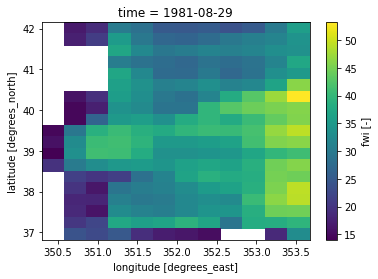

In [19]:
# Plot a layer in August (1981-08-29)
fwi[30*8,:,:].plot();

What is the mean value over the area for each day (over the first 3 years)?

In [20]:
fwi_mean = fwi[1:(3*365)].mean(dim = ('lon', 'lat'))

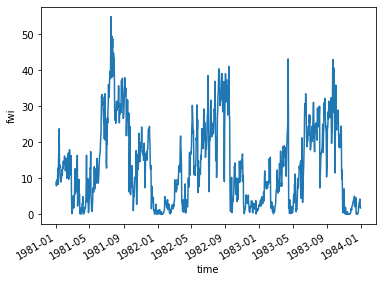

In [21]:
# Plot the mean value over a 3-year period
fwi_mean.plot();

As expected, FWI value oscillate between 0 and 50+ with highest values in summer. A data-driven way to derive danger thresholds makes use of percentiles. The set below usually corresponds to very low, low, moderate, high, very high and extreme danger: 

In [22]:
# Define percentiles of interest to generate danger threshold maps
fire_percentiles = [0.75, 0.85, 0.90, 0.95, 0.98]

Below are two different approaches.

#### Regional Danger Levels

If the same thresholds have to be used throughtout the year and for large areas, the percentiles can be simply calculated over the full time series record and then spatially averaged.

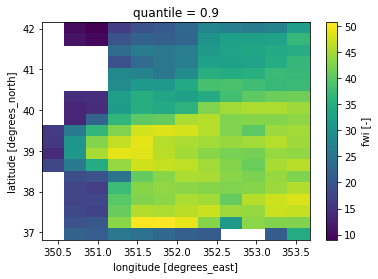

In [23]:
# Calculate the maps of percentiles as threshold of danger
danger_threshold_maps = fwi.quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)
# Plot the map corresponding to the 90th percentile = high danger
danger_threshold_maps[2].plot();

In [24]:
# Obtain fixed set of thresholds as the median over the area for each time step (as integers)
# Very low < 25
# Low = 25-33
# Moderate = 33-37
# High = 37-43
# Very high = 43-50
# Extreme > 50
danger_threshold_maps.median(dim=('lon', 'lat')).round(0)

<xarray.DataArray 'fwi' (quantile: 5)>
array([25., 33., 37., 43., 50.])
Coordinates:
  * quantile  (quantile) float64 0.75 0.85 0.9 0.95 0.98

This approach generally tends to underestimate danger levels because the sample contains many low values occurring during autumn and winter months. As an alternative, one could only consider records during the fire season (if known in advance). Let's assume the fire season in Attica goes from June to August (JJA):

In [25]:
# Find indices corresponding to JJA
idx = np.concatenate(np.where((fwi.time.dt.month >= 6)  & (fwi.time.dt.month <= 8)))

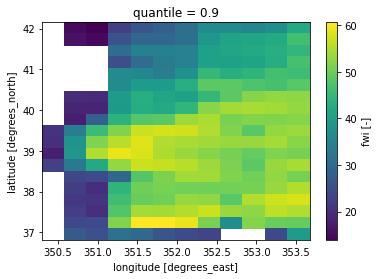

In [26]:
# Calculate quantiles only over JJA
danger_threshold_maps_JJA = fwi[idx,:,:].quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)
# Plot the map corresponding to the 90th percentile = high danger
danger_threshold_maps_JJA[2].plot();

In [27]:
# Obtain fixed set of thresholds as the median over the area for each time step
# Very low < 39
# Low = 39 - 44
# Moderate = 44 - 47
# High = 47 - 52
# Very high = 52 - 57
# Extreme > 57
danger_threshold_maps_JJA.median(dim=('lon', 'lat')).round(0)

<xarray.DataArray 'fwi' (quantile: 5)>
array([39., 44., 47., 52., 57.])
Coordinates:
  * quantile  (quantile) float64 0.75 0.85 0.9 0.95 0.98

This approach relies on the a-priori estimate of the length of the fire season, which is not always trivial. Also, spatial averaging over large regions should be avoided (if possible) to remove smoothing effects.

These thresholds are much higher that EFFIS ones. How would the re-classified forecast look like using these local thresholds?

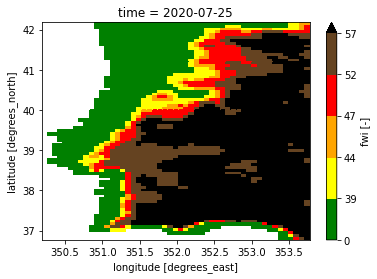

In [28]:
# Open raw RT HRES forecast for Portugal, issued on 16th July 2018 (10 days before the fires)
fct = xr.open_dataset("./eodata/cems_geff/202007_Portugal/rt_hr/ECMWF_FWI_20200716_1200_hr.nc")
# Plot the re-classified forecast, Day 10
fct.fwi[9].plot(levels = [0, 39.0, 44.0, 47.0, 52.0, 57.0],
                colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
                label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme']);

#### Maps of danger levels based on the daily fire climatology

More often, local authorities estimate statistical thresholds based on the daily climatology on a cell-by-cell basis. The thresholds are delivered in the form of a map, which allows to avoid any smoothing effect due to spatial averaging. 
To understand how this works, let's assume we want to estimate danger level maps for 25th July.

In [29]:
# Find indices of dates corresponding to 25rd July
idx = np.concatenate(np.where((fwi.time.dt.day == 25) & (fwi.time.dt.month == 7)))

Let's expand this range of indices to include 4 days before and after each date

In [30]:
indices_list = []
for i in idx:
    indices_list.append(list(range(i - 4, i + 4 + 1)))
    
# Concatenate all the indices in a 1-dimensional array
indices = np.concatenate(indices_list)

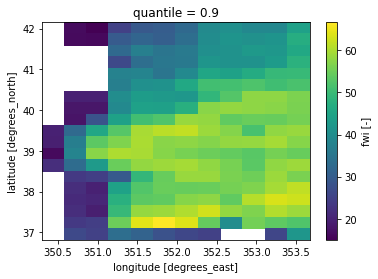

In [31]:
# Calculate the maps of percentiles as threshold of danger
fwiJuly = fwi[indices,:,:]
daily_danger_threshold_maps = fwiJuly.quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)
# Plot the map of daily climatological 90th percentile as threshold of high danger
daily_danger_threshold_maps[2].plot();

This map is very similar to the one calculated previously, which means that the fire weather in Portugal does not vary much over the fire season.

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./62_CEMS_GEFF_FWI_harmonized_danger_classes.ipynb"><< 62 - CEMS GEFF FWI harmonized danger classes </a><span style="float:right;"><a href="./71_workflow_portugal_fires_2020.ipynb">71 - Workflow - Portugal Fires 2020 >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.